# Battle of Neighbourhood | Best possible localities for buying or renting a property in Kolkata

## Importing required libraries

In [1]:
import numpy as np
import pandas as pd

import json
!pip install bs4
from bs4 import BeautifulSoup as bs
from geopy.geocoders import Nominatim

import requests
from pandas.io.json import json_normalize
!pip install geocoder
import geocoder

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib.pyplot as plt
from matplotlib import style

!pip install -U scikit-learn
!pip install scipy

from sklearn.cluster import KMeans

import folium
import requests
print('Libraries imported.')

Libraries imported.


## Webscraping data from Wikipedia page and loading it in a dataframe and then to csv

In [2]:
lat=[];lng=[];nei=[];bur=[];pin=[]

for i in range(1,145):
  df=pd.read_html('https://en.wikipedia.org/wiki/Ward_No._'+str(i)+',_Kolkata_Municipal_Corporation')
  df=df[0]

  #Handling edge cases for column values
  if(i==1):
    j=11;k=16;l=3;n=7
  elif(i==2):
    j=11;k=15;l=3;n=7
  elif(i==101):
    i=i+1;j=11;k=17;l=4;n=8
  elif(i==114):
    j=13;k=17;l=4;n=9
  else:
    j=10;k=14;l=3;n=7

  st=df.loc[l]['Ward No. '+str(i)]
  s=st.split()
  latnew=s[-2].replace('\ufeff','').split('°')[0]
  lngnew=s[-1].split('°')[0]

  neinew=df.loc[n]['Ward No. '+str(i)+'.1']
  burnew=df.loc[j]['Ward No. '+str(i)+'.1']
  pinnew='NA' if i>=142 and i<=145 else df.loc[k]['Ward No. '+str(i)+'.1'] #Handling edge cases for blank pincodes

  lat.append(float(latnew))
  lng.append(float(lngnew))
  nei.append(str(neinew))
  bur.append(str(burnew))
  pin.append(str(pinnew))

df = pd.DataFrame({'Ward no':[x for x in range(1,145)],'Burough':bur,'PIN Code': pin,'Neighbourhood':nei,'Latitude':lat,'Longitude':lng})
df.set_index('Ward no',inplace=True)
df.head(10)

,Burough,PIN Code,Neighbourhood,Latitude,Longitude
Ward no,,,,,
1,1,700 003,Cossipore,22.617889,88.370556
2,1,"700030, 700050",Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,22.628056,88.384444
3,1,700 037,"Belgachia, Duttabagan",22.604444,88.383333
4,1,700 002/ 700 037,Paikpara,22.613056,88.379444
5,1,700 002,"Tala, Belgachia",22.608889,88.379694
6,1,700 002,"Chitpur, Cossipore",22.610863,88.371213
7,1,700 003,Bagbazar,22.603567,88.365806
8,1,700 003,"Bagbazar, Shobhabazar",22.601806,88.366500
9,1,700 004,"Shobhabazar, Kumortuli",22.595889,88.365306


In [3]:
# Saving dataframe to csv locally (Optional Step)
# df.to_csv('Kolkata.csv')
# df=pd.read_csv('Kolkata.csv')

In [4]:
df.shape

(144, 5)

In [5]:
df.describe()

,Latitude,Longitude
count,144.000000,144.000000
mean,22.539073,88.352142
std,0.042767,0.031927
min,22.456589,88.254556
25%,22.504333,88.336507
50%,22.540771,88.360938
75%,22.576410,88.372452
max,22.628056,88.409694


## Plotting the datapoints in a folium map

In [6]:
import folium
kol_wards = folium.Map(location=[22.5726, 88.3639], zoom_start=11)
for lat, lng, neighborhood in zip(df['Latitude'], df['Longitude'], df['Neighbourhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=4,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#87cefa',
        fill_opacity=0.5,
        parse_html=False).add_to(kol_wards)
kol_wards

## Fetching nearby venue data for each ward

In [7]:
CLIENT_ID = 'JBI4QMBHWIBQDGDEIKMDFU0C4VXHBYYNQDCNS21EXBHLFWDU'
CLIENT_SECRET = 'PZDZYGUY2W4X5TLPCKNETKBBDCKQIRKISDFTZWZLNU03WP5F'
VERSION = '20210721'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: Hidden')
print('CLIENT_SECRET: Hidden')

Your credentails:
CLIENT_ID: Hidden
CLIENT_SECRET: Hidden


In [8]:
def getNearbyVenues(names, latitudes, longitudes, radius=2000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
        
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, CLIENT_SECRET, VERSION, lat, lng, radius, LIMIT)
        
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        venues_list.append([( name, lat, lng, v['venue']['name'], v['venue']['location']['lat'], v['venue']['location']['lng'], v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 'Neighborhood Latitude', 'Neighborhood Longitude', 'Venue', 'Venue Latitude', 'Venue Longitude', 'Venue Category']
    
    return(nearby_venues)

In [9]:
kolkata_venues = getNearbyVenues(names=df['Neighbourhood'], latitudes=df['Latitude'],longitudes=df['Longitude'])
kolkata_venues.head()

Cossipore
Sinthee (Ramlila Bagan-Biswanath Colony-Roypara), Sobji Bagan, Satpukur
Belgachia, Duttabagan
Paikpara
Tala, Belgachia
Chitpur, Cossipore
Bagbazar
Bagbazar, Shobhabazar
Shobhabazar, Kumortuli
Shyambazar, Shobhabazar, Shyampukur, Hatibagan
Shyambazar, Burtolla, Hatibagan
Shyambazar (Fariapukur)
Ultadanga (Daspara-Muchi Bazar-Telenga Bagan-Surir Bagan)
Ultadanga (Murari Pukur), Bagmari
Maniktala (Bangiya Sahitya Parishad-Halsi Bagan-Gouribari)
Maniktala (Bangiya Sahitya Parishad-Goa Bagan)
Darjipara
Shobhabazar, Beniatola (Garanhatta)
Shobhabazar, Beniatola (Ahiritola)
Beniatola (Ahiritola)
Jorabagan, Malapara
Posta
Posta, Jorasanko
Jorabagan, Pathuriaghata
Rambagan, Girish Park, Jorasanko, Simla
Ramdulal Sarkar Street and Hedua Park
Maniktala
Maniktala, Garpar, Rajabazar
Narkeldanga
Narkeldanga, Phoolbagan, Kankurgachi
Kankurgachi, Phoolbagan (Kadapara)
Kankurgachi, Bagmari, Ultadanga (Murari Pukur-Sreekrishna Colony)
Phoolbagan (Subhas Sarovar), Beliaghata (Kulia)
Beliaghata 

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Cossipore,22.617889,88.370556,Golbari,22.601742,88.373927,Indian Restaurant
1,Cossipore,22.617889,88.370556,Five Point Crossing,22.601878,88.373793,Plaza
2,Cossipore,22.617889,88.370556,Kotak Mahindra Bank - Branch/ATM,22.603536,88.369274,Bank
3,Cossipore,22.617889,88.370556,Sinthee More,22.630965,88.378465,Plaza
4,Cossipore,22.617889,88.370556,Baghbazar Ghat,22.604887,88.364826,River


##  Loading venue data in our Dataframe and displaying the count for each

In [10]:
kolkata_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Alipore,28,28,28,28,28,28
"Ashok Nagar, Kudghat, Tollygunge Club, Regent Park (Shantigarh-Regent Colony-Nehru Colony-Vivekananda Nagar-Moor Avenue-Shanti Nagar-Composite Housing Estate)",14,14,14,14,14,14
"Badartala, Rajabagan",4,4,4,4,4,4
Bagbazar,14,14,14,14,14,14
"Bagbazar, Shobhabazar",14,14,14,14,14,14
...,...,...,...,...,...,...
Tollygunge Circular Road (Sirity-Senhati Colony),12,12,12,12,12,12
Ultadanga (Daspara-Muchi Bazar-Telenga Bagan-Surir Bagan),25,25,25,25,25,25
"Ultadanga (Murari Pukur), Bagmari",32,32,32,32,32,32


In [11]:
print('There are {} uniques categories.'.format(len(kolkata_venues['Venue Category'].unique())))

There are 132 uniques categories.


## Getting dummy variables for the categorical venues for our unsupervised clusturing

In [12]:
kolkata_onehot = pd.get_dummies(kolkata_venues[['Venue Category']], prefix="", prefix_sep="")
kolkata_onehot['Neighborhood'] = kolkata_venues['Neighborhood'] 

fixed_columns = [kolkata_onehot.columns[-1]] + list(kolkata_onehot.columns[:-1])
kolkata_onehot = kolkata_onehot[fixed_columns]

kolkata_onehot.head()

,Zoo,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Department Store,Dessert Shop,Dhaba,Diner,Dumpling Restaurant,Electronics Store,...,Nightclub,North Indian Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Port,Pub,Racetrack,Residential Building (Apartment / Condo),Restaurant,River,Sandwich Place,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## Grouping the data with the mean of frequency

In [13]:
kolkata_grouped = kolkata_onehot.groupby('Neighborhood').mean().reset_index()
kolkata_grouped

,Neighborhood,Zoo,ATM,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Awadhi Restaurant,BBQ Joint,Bakery,Bank,Bar,Beer Bar,Beer Garden,Bengali Restaurant,Bistro,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Breakfast Spot,Brewery,Burger Joint,Bus Station,Bus Stop,Business Service,Café,Chinese Restaurant,Clothing Store,Coffee Shop,Construction & Landscaping,Convenience Store,Cricket Ground,Department Store,Dessert Shop,Dhaba,Diner,Dumpling Restaurant,...,Nightclub,North Indian Restaurant,Paper / Office Supplies Store,Park,Performing Arts Venue,Pharmacy,Pier,Pizza Place,Planetarium,Platform,Playground,Plaza,Pool,Port,Pub,Racetrack,Residential Building (Apartment / Condo),Restaurant,River,Sandwich Place,Shoe Store,Shopping Mall,Smoke Shop,Snack Place,Soccer Stadium,South Indian Restaurant,Sports Club,Stadium,Steakhouse,Supermarket,Tea Room,Tex-Mex Restaurant,Thai Restaurant,Theme Park,Theme Restaurant,Tibetan Restaurant,Train Station,Tram Station,Vegetarian / Vegan Restaurant,Yoga Studio
0,Alipore,0.035714,0.000000,0.0,0.0,0.0,0.0,0.035714,0.035714,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.142857,0.035714,0.0,0.000000,0.0,0.0,0.0,0.000000,0.035714,0.071429,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.035714,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.035714,0.000000,0.0,0.035714,0.0,0.035714,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
1,"Ashok Nagar, Kudghat, Tollygunge Club, Regent ...",0.000000,0.142857,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.142857,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.142857,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.071429,0.0,0.000000,0.0,0.000000,0.071429,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
2,"Badartala, Rajabagan",0.000000,0.750000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.250000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.00000,0.0
3,Bagbazar,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.071429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.071429,0.000000,0.00000,0.0
4,"Bagbazar, Shobhabazar",0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.071429,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.00000,0.071429,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.000000,...,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.071429,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.071429,0.000000,0.00000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137,Tollygunge Circular Road (Sirity-Senhati Colony),0.000000,0.166667,0.0,0.0,0.0,0.0,0.08

In [14]:
kolkata_grouped.shape

(142, 132)

## Displaying top 5 venues in each ward

In [15]:
num_top_venues = 5
for neigh in kolkata_grouped['Neighborhood']:
    print("----"+neigh+"----")
    temp = kolkata_grouped[kolkata_grouped['Neighborhood'] == neigh].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Alipore----
                  venue  freq
0                  Café  0.14
1     Indian Restaurant  0.07
2                 Dhaba  0.07
3  Fast Food Restaurant  0.07
4           Pizza Place  0.07


----Ashok Nagar, Kudghat, Tollygunge Club, Regent Park (Shantigarh-Regent Colony-Nehru Colony-Vivekananda Nagar-Moor Avenue-Shanti Nagar-Composite Housing Estate)----
                 venue  freq
0  Dumpling Restaurant  0.14
1                  ATM  0.14
2                 Café  0.14
3               Lounge  0.07
4   Tex-Mex Restaurant  0.07


----Badartala, Rajabagan----
                            venue  freq
0                             ATM  0.75
1                          Bakery  0.25
2                   Movie Theater  0.00
3              Mughlai Restaurant  0.00
4  Multicuisine Indian Restaurant  0.00


----Bagbazar----
                venue  freq
0                Park  0.14
1   Indian Restaurant  0.07
2  Bengali Restaurant  0.07
3   Indian Sweet Shop  0.07
4              Market  0.07


-

## Saving the top 5 venue data in dataframe

In [16]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [17]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']

columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = kolkata_grouped['Neighborhood']

for ind in np.arange(kolkata_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(kolkata_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.shape

(142, 11)

## Determination of value of K for K-means clustering using Elbow-point method

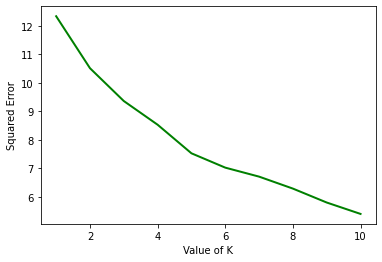

In [18]:
SquaredError=[]
kolkata_grouped_clustering = kolkata_grouped.drop('Neighborhood', 1)
for i in range (1,11):
  kmeans=KMeans(n_clusters=i,max_iter=1000)
  kmeans.fit(kolkata_grouped_clustering)
  SquaredError.append(kmeans.inertia_)

plt.plot(range(1,11),SquaredError,color='g',linewidth='2')
plt.xlabel("Value of K")
plt.ylabel("Squared Error")
plt.show()

In [19]:
#From the previous plot, by observation we can determine that kcluster=5 from elbow point method 
kclusters = 5
kolkata_grouped_clustering = kolkata_grouped.drop('Neighborhood', 1)
kmeans = KMeans(n_clusters=kclusters, random_state=1).fit(kolkata_grouped_clustering)
print(kmeans.labels_)

[1 1 2 0 0 4 1 1 1 1 1 1 4 4 1 0 2 1 1 1 1 1 1 1 1 0 0 1 1 1 1 0 1 1 1 1 1
 1 1 1 1 0 1 1 1 0 1 1 1 0 0 1 1 1 1 1 1 2 0 2 2 0 1 4 4 4 1 4 1 1 1 1 1 1
 0 0 0 1 1 1 1 1 1 1 2 2 1 0 0 0 0 0 2 2 2 1 1 1 0 1 1 1 1 1 1 0 0 0 0 0 1
 1 1 3 1 1 1 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 1 1]


In [20]:
len(kmeans.labels_)

142

In [21]:
df.head()

,Burough,PIN Code,Neighbourhood,Latitude,Longitude
Ward no,,,,,
1,1,700 003,Cossipore,22.617889,88.370556
2,1,"700030, 700050",Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,22.628056,88.384444
3,1,700 037,"Belgachia, Duttabagan",22.604444,88.383333
4,1,700 002/ 700 037,Paikpara,22.613056,88.379444
5,1,700 002,"Tala, Belgachia",22.608889,88.379694


## Merging the clustured label data with our dataframe

In [22]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

In [23]:
kolkata_merged = df
kolkata_merged = kolkata_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighbourhood')
kolkata_merged.head()

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
1,1,700 003,Cossipore,22.617889,88.370556,0,Plaza,Playground,River,Bank,Indian Restaurant,Vegetarian / Vegan Restaurant,Train Station,Metro Station,Dessert Shop,Dhaba
2,1,"700030, 700050",Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,22.628056,88.384444,0,Plaza,Gift Shop,Playground,Fast Food Restaurant,Burger Joint,Liquor Store,Park,Music Store,Pizza Place,Dessert Shop
3,1,700 037,"Belgachia, Duttabagan",22.604444,88.383333,0,Indian Restaurant,Train Station,Indian Sweet Shop,Indie Movie Theater,Market,Asian Restaurant,Pizza Place,Bengali Restaurant,Café,Plaza
4,1,700 002/ 700 037,Paikpara,22.613056,88.379444,0,Plaza,Train Station,Metro Station,Platform,Bakery,Playground,Indian Restaurant,Diner,Dhaba,Dessert Shop
5,1,700 002,"Tala, Belgachia",22.608889,88.379694,0,Train Station,Indian Restaurant,Asian Restaurant,Bengali Restaurant,Plaza,Playground,Platform,Metro Station,Bakery,Indie Movie Theater


## Finally our Kolkata map is ready with clustured data

In [24]:
latitude=22.5726
longitude=88.3639
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

markers_colors = []
for lat, lon, poi, cluster in zip(kolkata_merged['Latitude'], kolkata_merged['Longitude'], kolkata_merged['Neighbourhood'],kmeans.labels_):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker([lat, lon], radius=5, popup=label, color=rainbow[cluster-1], fill=True, fill_color=rainbow[cluster-1], fill_opacity=0.7).add_to(map_clusters)
map_clusters

## Analysing Cluster 0

In [25]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 0]

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
1,1,700 003,Cossipore,22.617889,88.370556,0,Plaza,Playground,River,Bank,Indian Restaurant,Vegetarian / Vegan Restaurant,Train Station,Metro Station,Dessert Shop,Dhaba
2,1,"700030, 700050",Sinthee (Ramlila Bagan-Biswanath Colony-Roypar...,22.628056,88.384444,0,Plaza,Gift Shop,Playground,Fast Food Restaurant,Burger Joint,Liquor Store,Park,Music Store,Pizza Place,Dessert Shop
3,1,700 037,"Belgachia, Duttabagan",22.604444,88.383333,0,Indian Restaurant,Train Station,Indian Sweet Shop,Indie Movie Theater,Market,Asian Restaurant,Pizza Place,Bengali Restaurant,Café,Plaza
4,1,700 002/ 700 037,Paikpara,22.613056,88.379444,0,Plaza,Train Station,Metro Station,Platform,Bakery,Playground,Indian Restaurant,Diner,Dhaba,Dessert Shop
5,1,700 002,"Tala, Belgachia",22.608889,88.379694,0,Train Station,Indian Restaurant,Asian Restaurant,Bengali Restaurant,Plaza,Playground,Platform,Metro Station,Bakery,Indie Movie Theater
6,1,700 002,"Chitpur, Cossipore",22.610863,88.371213,0,Indian Restaurant,Indie Movie Theater,Bengali Restaurant,Market,Fast Food Restaurant,Plaza,Indian Sweet Shop,Train Station,Metro Station,Diner
7,1,700 003,Bagbazar,22.603567,88.365806,0,Park,Bengali Restaurant,Pizza Place,Café,Plaza,Fast Food Restaurant,Metro Station,Market,Indian Restaurant,Train Station
8,1,700 003,"Bagbazar, Shobhabazar",22.601806,88.366500,0,Park,Bengali Restaurant,Pizza Place,Café,Plaza,Fast Food Restaurant,Metro Station,Market,Indian Restaurant,Train Station
9,1,700 004,"Shobhabazar, Kumortuli",22.595889,88.365306,0,History Museum,Park,Indian Restaurant,Bakery,Metro Station,Market,Fast Food Restaurant,Plaza,Bengali Restaurant,Café


## Analysing Cluster 1

In [26]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 1]

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
29,3,700 011,Narkeldanga,22.579250,88.379833,1,Café,Department Store,Train Station,Pizza Place,Juice Bar,Dhaba,Park,Platform,Plaza,Bus Stop
30,3,700 011,"Narkeldanga, Phoolbagan, Kankurgachi",22.576250,88.387528,1,Café,Indian Restaurant,Fast Food Restaurant,Train Station,Multiplex,Bus Station,Platform,Pizza Place,Department Store,Dhaba
31,3,700 006,"Kankurgachi, Phoolbagan (Kadapara)",22.579861,88.388917,1,Café,Indian Restaurant,Multiplex,Fast Food Restaurant,Italian Restaurant,Market,Fried Chicken Joint,Food Truck,Food,Bookstore
32,3,700 006,"Kankurgachi, Bagmari, Ultadanga (Murari Pukur-...",22.582861,88.391917,1,Café,Indian Restaurant,Fast Food Restaurant,Bookstore,Multiplex,Pizza Place,Coffee Shop,Shopping Mall,Department Store,Bakery
33,3,700 010,"Phoolbagan (Subhas Sarovar), Beliaghata (Kulia)",22.564861,88.399306,1,Café,Indian Restaurant,Multiplex,Hotel,Fast Food Restaurant,Pizza Place,Chinese Restaurant,Convenience Store,Department Store,Dhaba
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131,14,700 060,Behala (Parnasree Pally),22.508135,88.301694,1,Ice Cream Shop,Movie Theater,Mughlai Restaurant,Clothing Store,Chinese Restaurant,Café,Fast Food Restaurant,Food,Flea Market,Field
132,14,"700 060, 700 034",Behala (Naskarpur-Bara Bagan-Pathakpara),22.507865,88.314694,1,Café,Mughlai Restaurant,Indian Restaurant,Ice Cream Shop,Movie Theater,Pizza Place,Clothing Store,Chinese Restaurant,Frozen Yogurt Shop,Steakhouse
142,16,NA,Joka,22.464889,88.331542,1,Bus Station,Pharmacy,Bakery,Business Service,Hostel,Indian Sweet Shop,Pizza Place,Chinese Restaurant,Café,Flea Market


## Analysing Cluster 2

In [27]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 2]

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
79,9,700 023,"Kidderpore (Babu Bazar), Mominpur, Majherhat, ...",22.533250,88.310611,2,ATM,Market,Awadhi Restaurant,Harbor / Marina,Yoga Studio,Fast Food Restaurant,Food Court,Food & Drink Shop,Food,Flea Market
80,9,700 023,"Kidderpore (Andaman Dock), Garden Reach (BNR C...",22.540325,88.300161,2,Harbor / Marina,Port,ATM,Food & Drink Shop,Food,Flea Market,Field,Fast Food Restaurant,Falafel Restaurant,Yoga Studio
124,16,"700 008, 700 063","Barisha, Thakurpukur",22.468675,88.316694,2,Pharmacy,Bakery,ATM,Restaurant,Food,Flea Market,Field,Fast Food Restaurant,Falafel Restaurant,Electronics Store
133,15,+91 33,Garden Reach (Akshay Kanan),22.538111,88.286556,2,ATM,Pier,Pizza Place,Harbor / Marina,Electronics Store,Food,Flea Market,Field,Fast Food Restaurant,Falafel Restaurant
136,15,700 018,Garden Reach (Metiabruz),22.539806,88.281556,2,Construction & Landscaping,ATM,Pizza Place,River,Electronics Store,Food,Flea Market,Field,Fast Food Restaurant,Falafel Restaurant
137,15,700 024 700 044,Garden Reach (Metiabruz-Lichu Bagan),22.548806,88.273556,2,Bakery,ATM,River,Botanical Garden,Yoga Studio,Food Court,Food & Drink Shop,Food,Flea Market,Field
138,15,700 018,Metiabruz (Panchpara-Kashyappara-Jabarhat),22.548806,88.268556,2,ATM,Bakery,River,Yoga Studio,Food Court,Food & Drink Shop,Food,Flea Market,Field,Fast Food Restaurant
139,15,"700 018, 700 044",Metiabruz (Bartala-Karbala),22.539806,88.267556,2,Yoga Studio,Bakery,ATM,River,Pizza Place,Food,Flea Market,Field,Fast Food Restaurant,Falafel Restaurant
140,15,"700 018, 700 044",Metiabruz (Kanthalberia-Mullickpara),22.546806,88.261556,2,Yoga Studio,Bakery,ATM,River,Food Court,Food & Drink Shop,Food,Flea Market,Field,Fast Food Restaurant


## Analysing Cluster 3

In [28]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 3]

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
127,14,"700 061, 700 063",Sarsuna (Sarsuna satellite township-Shakuntala...,22.478235,88.288694,3,Mobile Phone Shop,Yoga Studio,Food Truck,Department Store,Dessert Shop,Dhaba,Diner,Dumpling Restaurant,Electronics Store,Falafel Restaurant


## Analysing Cluster 4

In [29]:
kolkata_merged.loc[kolkata_merged['Cluster Labels'] == 4]

,Burough,PIN Code,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
Ward no,,,,,,,,,,,,,,,,
100,10,700 047,Garia (Ramgarh-Naktala-Laxmi Narayan Colony),22.473833,88.371694,4,Metro Station,Café,Plaza,Dumpling Restaurant,Supermarket,Falafel Restaurant,Food & Drink Shop,Food,Flea Market,Field
101,11,"700 084, 700 094, 700 086","Baghajatin (Ajanta Park), Garia (Phool Bagan-G...",22.476833,88.381694,4,Metro Station,Café,Plaza,Shopping Mall,Multiplex,Yoga Studio,Falafel Restaurant,Food,Flea Market,Field
109,12,"700 094, 700 099","Haltu (Kalikapur), Santoshpur (Borakhola-Nanda...",22.481833,88.400694,4,Metro Station,Multiplex,Bakery,Shopping Mall,Grocery Store,Dumpling Restaurant,Electronics Store,Falafel Restaurant,Diner,Dhaba
110,11,"700 094, 700 084",Garia (Baishnabghata Patuli Township-Kanungo P...,22.473833,88.382694,4,Metro Station,Café,Plaza,Shopping Mall,Multiplex,Yoga Studio,Falafel Restaurant,Food,Flea Market,Field
111,11,"700 084, 700 096, 700 154",Garia–Brahmapur–Kamdahari-Boral,22.462833,88.370694,4,Metro Station,Café,Supermarket,Plaza,Bus Station,Diner,Dumpling Restaurant,Dhaba,Electronics Store,Food Truck
112,11,700 047,Bansdroni (Rania-Roy Nagar),22.467833,88.365694,4,Metro Station,Café,Plaza,Yoga Studio,Falafel Restaurant,Food,Flea Market,Field,Fast Food Restaurant,Dumpling Restaurant
113,11,700070,Bansdroni (Jaysree Park-Kalitala),22.472833,88.354694,4,Café,Metro Station,Supermarket,Dumpling Restaurant,Mughlai Restaurant,Food & Drink Shop,Food,Flea Market,Field,Falafel Restaurant
